In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 9)
sns.set(rc={"figure.figsize":(12, 4)})

## Data exploration


In [2]:
df = pd.read_csv('heart_2020.csv')
df['HeartDisease'] = df['HeartDisease'].replace(['Yes', 'No'], [1, 0])
CATEGORICAL_FEATURES = []
NUMERIC_FEATURES = []
for i in df.columns:
    if df[i].dtype == 'object':
        
        CATEGORICAL_FEATURES.append(i)
        if not str(i) == 'Diabetic':
            df[i] = df[i].replace(['Yes', 'No'], [1, 0])
    elif df[i].dtype == 'float64':
        NUMERIC_FEATURES.append(i)
    else:
        continue


In [3]:
df.dtypes

HeartDisease          int64
BMI                 float64
Smoking               int64
AlcoholDrinking       int64
Stroke                int64
PhysicalHealth        int64
MentalHealth          int64
DiffWalking           int64
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity      int64
GenHealth            object
SleepTime             int64
Asthma                int64
KidneyDisease         int64
SkinCancer            int64
dtype: object

In [4]:
for i in CATEGORICAL_FEATURES:
    print(df.groupby(str(i)).HeartDisease.agg(['count', 'mean']).sort_values('mean', ascending=False), '\n\n')
for i in NUMERIC_FEATURES:
    print(df.groupby(str(i)).HeartDisease.agg(['count', 'mean']).sort_values('mean', ascending=False), '\n\n')


          count      mean
Smoking                  
1        131908  0.121577
0        187887  0.060334 


                  count      mean
AlcoholDrinking                  
0                298018  0.088022
1                 21777  0.052395 


         count      mean
Stroke                  
1        12069  0.363659
0       307726  0.074690 


              count      mean
DiffWalking                  
1             44410  0.225805
0            275385  0.062985 


         count      mean
Sex                     
Male    151990  0.106185
Female  167805  0.066947 


             count      mean
AgeCategory                 
80 or older  24153  0.225603
75-79        21482  0.188483
70-74        31065  0.156028
65-69        34151  0.120084
60-64        33686  0.098765
55-59        29757  0.073999
50-54        25382  0.054487
45-49        21791  0.034143
40-44        21006  0.023136
35-39        20550  0.014404
30-34        18753  0.012051
25-29        16955  0.007844
18-24        21064 

<AxesSubplot:xlabel='Race', ylabel='HeartDisease'>

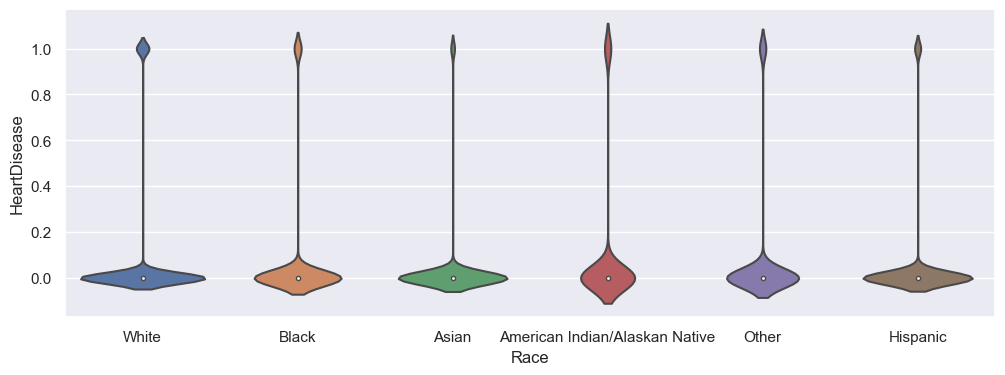

In [5]:
# Race => cultural values, habits,...
sns.violinplot(y='HeartDisease', x='Race', data=df)

In [6]:
df.AgeCategory.value_counts()

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

In [7]:
from numpy import random as rd 
df['Age'] = df.AgeCategory.apply(lambda x: rd.randint(int(x[:2]), int(x[3:])) if not str(x) == '80 or older' else rd.randint(80, 100))
df.corr()['HeartDisease'].sort_values(ascending=False)

HeartDisease        1.000000
Age                 0.235347
DiffWalking         0.201258
Stroke              0.196835
PhysicalHealth      0.170721
KidneyDisease       0.145197
Smoking             0.107764
SkinCancer          0.093317
BMI                 0.051803
Asthma              0.041444
MentalHealth        0.028591
SleepTime           0.008327
AlcoholDrinking    -0.032080
PhysicalActivity   -0.100030
Name: HeartDisease, dtype: float64

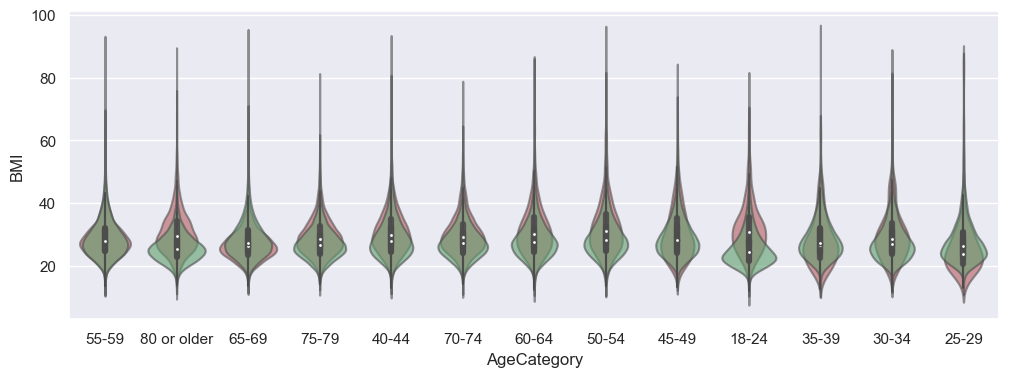

In [8]:
#BMI if heartdisease=1 vs BMI if heartdisease=0 for a given age
ax_1 = sns.violinplot(x='AgeCategory', y='BMI', data = df[df.HeartDisease == 1], color = 'r')
ax_2 = sns.violinplot(x='AgeCategory', y='BMI', data = df[df.HeartDisease == 0], color='g')
for violin1, violin2 in zip(ax_1.collections[::2], ax_2.collections[::2]):
    violin1.set_alpha(0.4)
    violin2.set_alpha(0.6) 

## Pre-processing

In [9]:
def preprocess_dataframe(df):
    df = df.copy()
    df['HeartDisease'] = df['HeartDisease'].replace(['Yes', 'No'], [1, 0])
    df['Age'] = df.AgeCategory.apply(lambda x: rd.randint(int(x[:2]), int(x[3:])) if not str(x) == '80 or older' else rd.randint(80, 100))
    return df
    
df = pd.read_csv('heart_2020.csv')


CATEGORICAL_FEATURES = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
NUMERIC_FEATURES = ['PhysicalHealth', 'Age']

df = preprocess_dataframe(df)


## Train The Model 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)
num_df = df_train[NUMERIC_FEATURES].copy()
cat_df = df_train[CATEGORICAL_FEATURES].copy()


def fit_transformers(df_train):
    one_hot_encoder = OneHotEncoder(drop='first')
    one_hot_encoder.fit(df_train[CATEGORICAL_FEATURES])
    scaler = StandardScaler()
    scaler.fit(compute_features(df_train, one_hot_encoder, scaler=None))
    return scaler, one_hot_encoder

def compute_features(df, one_hot_encoder, scaler):
    df = preprocess_dataframe(df)
    cat_features = one_hot_encoder.transform(df[CATEGORICAL_FEATURES])
    cat_df = pd.DataFrame(cat_features.todense(), columns=one_hot_encoder.get_feature_names()).reset_index(drop=True)
    num_df = df[NUMERIC_FEATURES].reset_index(drop=True)
    features = pd.concat([num_df, cat_df], axis=1)
    if scaler:
        features = pd.DataFrame(scaler.transform(features), columns=features.columns)
    return features
    

scaler, one_hot_encoder = fit_transformers(df_train)

X_train = compute_features(df_train, one_hot_encoder, scaler)
y_train = df_train.HeartDisease

X_test = compute_features(df_test, one_hot_encoder, scaler)
y_test = df_test.HeartDisease

c:\Users\Desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

model = LogisticRegression()
baseline = DummyClassifier(strategy='most_frequent')
advanced_model = XGBClassifier()

model.fit(X_train, y_train)
baseline.fit(X_train, y_train)
advanced_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     73137
           1       0.53      0.11      0.18      6812

    accuracy                           0.92     79949
   macro avg       0.72      0.55      0.57     79949
weighted avg       0.89      0.92      0.89     79949



In [13]:
print(classification_report(y_test, advanced_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     73137
           1       0.53      0.09      0.16      6812

    accuracy                           0.92     79949
   macro avg       0.72      0.54      0.56     79949
weighted avg       0.89      0.92      0.89     79949



In [14]:
print(classification_report(y_test, baseline.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     73137
           1       0.00      0.00      0.00      6812

    accuracy                           0.91     79949
   macro avg       0.46      0.50      0.48     79949
weighted avg       0.84      0.91      0.87     79949



In [15]:
# Where inaccuracies(first ones) happen
comp_list = advanced_model.predict(X_test).tolist()
l = []
res = 0
for i, j in zip(comp_list[:300], y_test.to_list()[:300]):
    if not i == j:
        print(res)
    res += 1

5
41
89
92
122
126
151
180
192
211
219
224
232
250
257
259
260
296


## Inaccuracies' Verification 

In [16]:
#1st inaccuracy (in 5th row)
df_test.loc[106720]

HeartDisease                  0
BMI                       22.32
Smoking                     Yes
AlcoholDrinking              No
Stroke                      Yes
PhysicalHealth               30
MentalHealth                  0
DiffWalking                 Yes
Sex                      Female
AgeCategory         80 or older
Race                      White
Diabetic                     No
PhysicalActivity             No
GenHealth                  Poor
SleepTime                     8
Asthma                       No
KidneyDisease               Yes
SkinCancer                   No
Age                          85
Name: 106720, dtype: object

In [17]:
#2nd inaccuracy (in 41st row)
df_test.loc[302564]


HeartDisease             1
BMI                  35.19
Smoking                Yes
AlcoholDrinking         No
Stroke                  No
PhysicalHealth           5
MentalHealth            30
DiffWalking             No
Sex                 Female
AgeCategory          65-69
Race                 White
Diabetic                No
PhysicalActivity        No
GenHealth             Good
SleepTime                5
Asthma                 Yes
KidneyDisease           No
SkinCancer              No
Age                     67
Name: 302564, dtype: object